# Load pretrained models for fine tuning

Assuming openai's gpt model is already downloaded from `ch05-load-gpt.ipynb`

In [2]:
import torch
import tiktoken
import myllm.gpt as gpt
import myllm.util
import myllm.data as data

In [3]:
# Initialize model
device = torch.device("cpu")
tokenizer = tiktoken.get_encoding('gpt2')


gpt_config = myllm.util.gpt_config()
# openai runs with qkv bias
gpt_config.update({'qkv_bias': True})
model = gpt.GPTModel(gpt_config)
model.to(device)


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

## Validating the model and weight

Just to check everything working

In [4]:
# load open weights
from gpt_download import download_and_load_gpt2

settings, params = download_and_load_gpt2(
    model_size="124M", models_dir="gpt2"
)

myllm.util.load_openai_weights_into_gpt(model, params)
print(model)

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe
GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)

In [5]:

text_1 = "Every effort moves you forward"
token_ids = model.generate(
    idx= myllm.util.text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=gpt_config["context_length"],
    temperature=1.4
)

print(myllm.util.token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward should house skull part nice company senior photo evil product lo don cases idea well


In [6]:
# text instructions
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    "'You are a winner you have been specially"
    " selected to receive $1000 cash or $2000 award.'"
)

token_ids= model.generate(
    idx= myllm.util.text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=gpt_config['context_length']
)

print(myllm.util.token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no':'You are a winner you have been specially selected to receive $1000 cash or $2000 award.' you orsp " "am to or winneranyn or' or you or $have 'selected by or to


### Updating Model for Classification task

Model struggles to follow instructions. Needs a new classification head, to adapt to the instruction _yes_ or _no_ when detecting spam

In [7]:
# freeze the model to stop training all layers
for param in model.parameters():
    param.requires_grad = False

# define new class head
torch.manual_seed(123)
num_classes = 2
model.out_head = torch.nn.Linear(
    in_features=gpt_config["emb_dim"],
    out_features=num_classes
)

# only last transformer and layerNorm will be trained in this fine tuning to improve performance
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True
for param in model.final_norm.parameters():
    param.requires_grad = True

In [8]:
# model still useable as before
# but now only returns a 2 dimensional tensor

inputs = tokenizer.encode('Do you have time')
inputs = torch.tensor(inputs).unsqueeze(0)


print(inputs.shape)
print(inputs)

with torch.no_grad(): 
    outputs = model(inputs)
print("out:")
print(outputs.shape)
print(outputs)


torch.Size([1, 4])
tensor([[5211,  345,  423,  640]])
out:
torch.Size([1, 4, 2])
tensor([[[-0.4326,  1.0296],
         [-1.4512,  4.8856],
         [-1.1513,  4.5541],
         [-0.7076,  2.4482]]])


## Define evaluation utilities 

In [9]:
def clac_accurracy_loader(data_loader, model, device, num_batches=None):
    model.eval();
    correct_predictions, num_examples = 0, 0
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]
            predicted_labels = torch.argmax(logits, dim=-1)
            num_examples += predicted_labels.shape[0]
            correct_predictions += ( (predicted_labels == target_batch).sum().item() )
        else:
            break
    return correct_predictions / num_examples

def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)[:, -1, :]
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss=0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [10]:
# applying the model

train, val, test = data.create_spam_dataloader_with_split(tokenizer, batch_size=10, num_workers=0)

device = torch.device('mps')
model.to(device)

torch.manual_seed(123)
train_accuracy = clac_accurracy_loader(
    train, model, device, num_batches=10
)

val_accuracy = clac_accurracy_loader(
    val, model, device, num_batches=10
)

test_accuracy = clac_accurracy_loader(
    test, model, device, num_batches=10
)


print(f'train acc: {train_accuracy*100:.2f}%')
print(f'val acc: {val_accuracy*100:.2f}%')
print(f'test acc: {test_accuracy*100:.2f}%')

train acc: 46.00%
val acc: 50.00%
test acc: 51.00%


In [11]:
# calculate initial loss for each dataset

with torch.no_grad():
    train_loss = calc_loss_loader(train, model, device, num_batches=5)
    val_loss = calc_loss_loader(val, model, device, num_batches=5)
    test_loss = calc_loss_loader(test, model, device, num_batches=5)


print(f'train loss: {train_loss:.3f}')
print(f'val loss: {val_loss:.3f}')
print(f'test loss: {test_loss:.3f}')


train loss: 4.006
val loss: 4.209
test loss: 3.646


# Fine Tune the model by retraining

In [12]:
def train_classifier_simple(
        model, train_loader, val_loader, optimizer, device, 
        num_epochs, eval_freq, eval_iter):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            examples_seen += input_batch.shape[0]
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = myllm.util.evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)

                print(f'Ep {epoch+1} (Step {global_step:06d}):'
                      f'Train loss {train_loss:.3f}, '      
                      f'Val loss {val_loss:.3f}, '      
                )

        train_accuracy = clac_accurracy_loader(train_loader, model, device, num_batches=eval_iter)

        val_accuracy = clac_accurracy_loader(val_loader, model, device, num_batches=eval_iter)

        print(f'Training accuracy: {train_accuracy*100:.2f}% | ', end="")
        print(f'Validation accuracy: {val_accuracy*100:.2f}')
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [13]:
# load spam dataset
# define splits train val test
# rerun training
# show results

train, val, test = data.create_spam_dataloader_with_split(tokenizer, batch_size=8, num_workers=0)

device = torch.device("mps")

import time
start_time = time.time()

# common practice in Deep Learning is using an optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5

train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train, val, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000):Train loss 2.307, Val loss 3.689, 
Ep 1 (Step 000050):Train loss 0.612, Val loss 0.689, 
Ep 1 (Step 000100):Train loss 0.615, Val loss 0.446, 
Training accuracy: 80.00% | Validation accuracy: 75.00
Ep 2 (Step 000150):Train loss 0.380, Val loss 0.398, 
Ep 2 (Step 000200):Train loss 0.385, Val loss 0.408, 
Ep 2 (Step 000250):Train loss 0.351, Val loss 0.391, 
Training accuracy: 87.50% | Validation accuracy: 82.50
Ep 3 (Step 000300):Train loss 0.375, Val loss 0.379, 
Ep 3 (Step 000350):Train loss 0.207, Val loss 0.373, 
Training accuracy: 87.50% | Validation accuracy: 85.00
Ep 4 (Step 000400):Train loss 0.360, Val loss 0.355, 
Ep 4 (Step 000450):Train loss 0.254, Val loss 0.365, 
Ep 4 (Step 000500):Train loss 0.255, Val loss 0.345, 
Training accuracy: 80.00% | Validation accuracy: 87.50
Ep 5 (Step 000550):Train loss 0.399, Val loss 0.321, 
Ep 5 (Step 000600):Train loss 0.266, Val loss 0.252, 
Training accuracy: 85.00% | Validation accuracy: 92.50
Training completed in 1

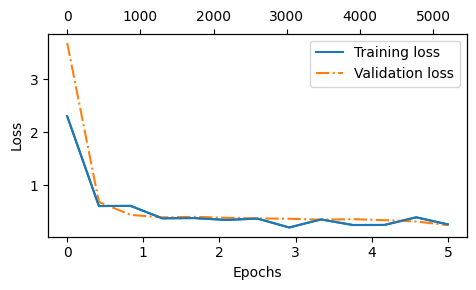

In [23]:
import matplotlib.pyplot as plt

def plot_values(epochs, examples, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5,3))
    ax1.plot(epochs, train_values, label=f"Training {label}")
    ax1.plot(
        epochs, val_values, linestyle="-.",
        label=f"Validation {label}"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    ax2 = ax1.twiny()
    ax2.plot(examples, train_values)
    ax2.set_ylabel("Examples seen")
    
    fig.tight_layout()
    plt.show()


epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)
